# Analysis of Eurozone Past, Present, and Future Riskless rates as represented by average yields on traded AAA-rated government bonds
The first thing we need to do is construct the so-called riskless yield curve for Euro. From this curve we can then derive required forward rates. I use [the Euro area yield curve constructed daily by the ECB](https://www.ecb.europa.eu/stats/financial_markets_and_interest_rates/euro_area_yield_curves/html/index.en.html) as proxies for riskless rates. These rates are derived from AAA-rated government bonds of the Euro area. Ideally, using swap rates might be better as government bond yields tend to be 3-4 basis points lower given that government bonds tend to be heavily used in repo trades. See the [this note from the ECB](https://www.ecb.europa.eu/pub/pdf/scpsps/ecb.sps27.en.pdf) for an explanation.

I use the following dataseries provided by the [Eurostat](https://ec.europa.eu/eurostat/web/main/data/database):
* `irt_euryld_d` &mdash; Euro yield curves (daily frequency). This series returns a dataset from which multiple yields can be extracted for maturities ranging from 3 months to 30 years: Instantaneous forward yield curve, Par yield curve, and Spot rate yield curve. I use the Spot rate yield curve in this notebook. The returned rates are presented using Annual percentage rates/yields and represent the average over a given business day. 

And one dataset from [the ECB](https://data.ecb.europa.eu/data):
* `FM.B.U2.EUR.4F.KR.DFR.LEV` &mdash; ECB Deposit Facility Rate for Euro Area. I use it as a proxy for overnight rate.

I construct the Euro riskfree curve using 40 curve points with the following terms:
* Overnight rate from the `ECBDFR` ECB Deposit Facility Rate for Euro Area series (adjusted for the actual/actual day count convention)
* 3-, 4-, 5-, 6-, 7-, 8-, 9-, 10-, 11-months spot rate from the `irt_euryld_d` Euro yield curve series
* 1-, 2-, 3-, ..., 29-, 30-years spot rate from the `irt_euryld_d` Euro yield curve series

In the `pricing.curves.YieldCurve` class I use cubic splines by default to interpolate when constructing the curve. See [this article](http://web.math.ku.dk/~rolf/HaganWest.pdf) for more details on interpolation methods if you want to know more. Cubic splines is pretty advanced.

In [1]:
# Uncomment if running in Google Colaboratory, otherwise the import of the curves module in the cell below will fail
# !git clone -l -s https://github.com/ilchen/US_Economic_Data_Analysis.git cloned-repo
# %cd cloned-repo

# Install the latest version of pandas-datareader and yfinance
# !pip install eurostat -U
# !pip install pandaSDMX -U

In [2]:
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import pandas_datareader.data as web
from pandas.tseries.offsets import BDay

import eurostat

import warnings
warnings.filterwarnings('ignore', message='optional dependency requests_cache*', category=RuntimeWarning)
import pandasdmx as sdmx

from datetime import date
from dateutil.relativedelta import relativedelta

from pricing import curves

In [3]:
today = date.today()

# The ECB provides yields for maturities ranging from 3 months till 30 years
month_maturities = range(3, 12)
year_maturities = range(1, 31)
maturities = ['M'+str(maturity) for maturity in month_maturities]
maturities.extend(['Y'+str(maturity) for maturity in year_maturities])

# Taking the last 12 business days, and converting to decimal fractions
euro_curves = eurostat.get_data_df('irt_euryld_d', filter_pars={
    'startPeriod': (today-BDay(12)).date(), 'freq': 'D',
    'yld_curv': 'SPOT_RT',
    'maturity': maturities,
    'bonds': 'CGB_EA_AAA', 'geo': 'EA'})
euro_curves = euro_curves.drop(euro_curves.columns[:2].append(euro_curves.columns[3:5]), axis=1)
euro_curves = euro_curves.set_index(euro_curves.columns[0]).T / 100.
euro_spot_rates = euro_curves.set_axis(pd.DatetimeIndex(euro_curves.index, 'B'))


# Retrieving the most recent ECB Deposit Facility Rate, and converting to decimal fractions
ecb = sdmx.Request('ECB')  
data_msg = ecb.data('FM', key='B.U2.EUR.4F.KR.DFR.LEV', params={'startPeriod': today-relativedelta(years=2)})
ecb_deposit_rate = sdmx.to_pandas(data_msg.data[0]).loc['B', 'U2', 'EUR', '4F', 'KR', 'DFR', 'LEV'] / 100.
ecb_deposit_rate = ecb_deposit_rate.set_axis(pd.DatetimeIndex(ecb_deposit_rate.index))

In [4]:
# Converting ECB Deposit rates from actual/360 to actual/actual
leap_year_cond = lambda idx: idx.year % 4 == 0 & ((idx.year % 100 != 0) | (idx.year % 400 == 0))
ecb_deposit_rate[leap_year_cond(ecb_deposit_rate.index)] *= 366. / 360
ecb_deposit_rate[np.invert(leap_year_cond(ecb_deposit_rate.index))] *= 365. / 360

In [5]:
date_now = euro_spot_rates.index[-1].date()

# Ensuring we go back to the last business day a week ago
date_1_week_ago = BDay(0).rollback(date_now - relativedelta(weeks=+1))
offsets = [relativedelta(months=+maturity) for maturity in month_maturities]
offsets.extend([relativedelta(years=+maturity) for maturity in year_maturities])
offsets = [relativedelta()] + offsets

In [6]:
# Define the riskless yield curve for Euro
curve = curves.YieldCurve(date_now, offsets,
        np.append(
            ecb_deposit_rate.iloc[-1],
            euro_spot_rates.iloc[-1].to_numpy()),
        compounding_freq=1)

# The ECB only posts updates on dates when a new rate is effective, hence I select the most latest ECB rate
# that is on 'date_1_week_ago' or earlier
curve_1_week_ago = curves.YieldCurve(date_now, offsets,
        np.append(
            ecb_deposit_rate.loc[ecb_deposit_rate.index<=date_1_week_ago].iloc[-1],
            euro_spot_rates.loc[date_1_week_ago,:].to_numpy()),
        compounding_freq=1)

In [7]:
curve_points = curve.get_curve_points(120)
curve_points_1_week_ago = curve_1_week_ago.get_curve_points(120)
curve_points.rename('Euro riskless rate', inplace=True)
curve_points_1_week_ago.rename(curve_points.name + ' (1 week prior)', inplace=True)

# Replacing indices for sake of better visualization
df = pd.concat([curve_points, curve_points_1_week_ago.set_axis(curve_points.index)], axis=1)

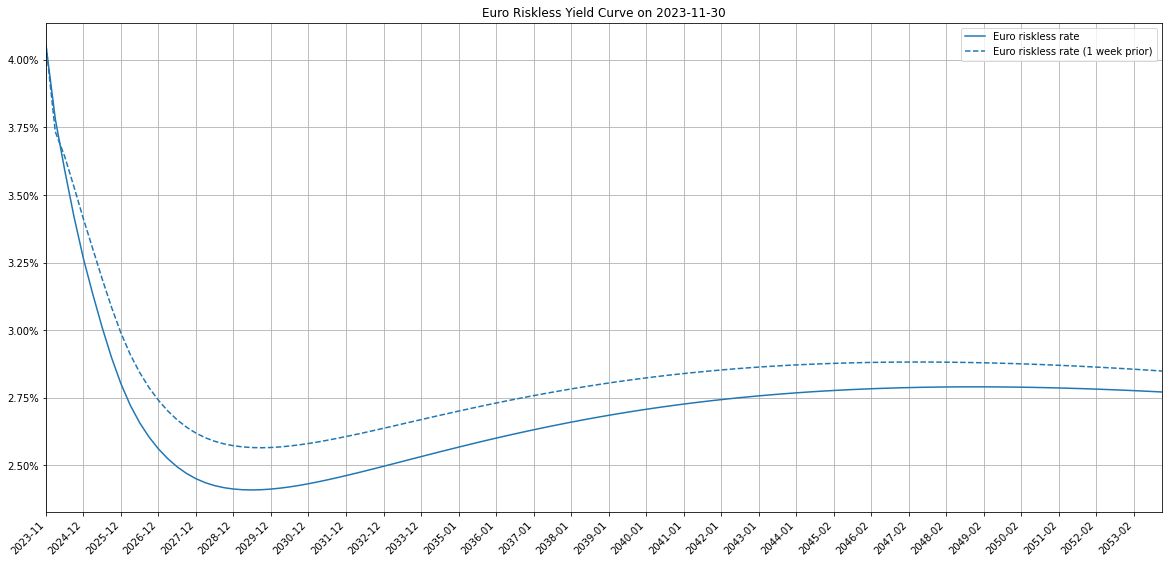

In [8]:
ax = df.iloc[:,:1].plot(figsize=(20,10), grid=True,
                       title='Euro Riskless Yield Curve on ' + date_now.strftime('%Y-%m-%d'),
                       xlim=(curve_points.index[0], curve_points.index[-1]),
                       xticks=curve_points.index[::4], xlabel='', rot=45)
df.iloc[:,1:].plot(ax=ax, grid=True, xticks=df.index[::4], rot=45, linestyle='--', color=['#1f77b4', '#ff7f0e'])
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map(lambda x: x.strftime('%Y-%m'), curve_points.index[::4])))

In [9]:
print('The curve on {:%Y-%m-%d} changed by an average of {:+.2f}bps compared to the week prior'
      .format(euro_spot_rates.index[-1].date(), 10000 * (df.iloc[:,0].mean() - df.iloc[:,1].mean())))

The curve on 2023-11-30 changed by an average of -11.88bps compared to the week prior


In [10]:
offset_in_years = 3

In [11]:
print('Average short-term (<{:d}y) riskless yield: {:.2%}'.format(offset_in_years,
    curve_points.loc[:(euro_spot_rates.index[-1].date()+relativedelta(years=+offset_in_years))].mean()))

Average short-term (<3y) riskless yield: 3.16%


In [12]:
print('Average long-term (>{:d}y) riskless yield: {:.2%}'.format(offset_in_years,
    curve_points.loc[(euro_spot_rates.index[-1].date()+relativedelta(years=+offset_in_years)):].mean()))

Average long-term (>3y) riskless yield: 2.66%


In [13]:
print('Long-term (>{:d}y) riskless yield: {:.2%}-{:.2%}'.format(offset_in_years,
    curve_points.loc[(euro_spot_rates.index[-1].date()+relativedelta(years=+offset_in_years)):].min(),
    curve_points.loc[(euro_spot_rates.index[-1].date()+relativedelta(years=+offset_in_years)):].max()))
print('Compared to: {:.2%}-{:.2%} a week ago'.format(
    curve_points_1_week_ago.loc[(euro_spot_rates.index[-1].date()+relativedelta(years=+offset_in_years)):].min(),
    curve_points_1_week_ago.loc[(euro_spot_rates.index[-1].date()+relativedelta(years=+offset_in_years)):].max()))

Long-term (>3y) riskless yield: 2.41%-2.79%
Compared to: 2.56%-2.88% a week ago


## Past, Present, and Future Eurozone Riskless rates
In this section of the notebook I calculate the past, present, and future 1-year, 2-year, 3-year, and 5-year riskless rates. As future riskless rates I use forward rates derived from the most recent riskless yield curve (see the graph above).

### Retrieving riskless rates for the past months

In [14]:
start_date = date(2022, 1, 1)

# The ECB provides yields for maturities ranging from 1 till 30 years
year_maturities = range(1, 6)
maturities = ['Y'+str(maturity) for maturity in year_maturities]

# Taking all the months starting on 'start_date' and converting to decimal fractions
euro_riskless_rates = eurostat.get_data_df('irt_euryld_m', filter_pars={
    'startPeriod': start_date, 'freq': 'M',
    'yld_curv': 'SPOT_RT',
    'maturity': maturities,
    'bonds': 'CGB_EA_AAA', 'geo': 'EA'})
euro_riskless_rates = euro_riskless_rates.drop(euro_riskless_rates.columns[:3].append(
    euro_riskless_rates.columns[4:5]), axis=1)
euro_riskless_rates = euro_riskless_rates.set_index(euro_riskless_rates.columns[0]).T / 100.
euro_riskless_rates = euro_riskless_rates.set_axis(pd.DatetimeIndex(euro_riskless_rates.index, 'MS'))

### Extending for future months using forward rates
I use the curve constructed from the most recent data that I created in the begining of this notebook to produce forward rates.

In [15]:
# First let's add the most recent spot rates for the current month
euro_riskless_rates = pd.concat([euro_riskless_rates, euro_spot_rates.loc[:,maturities].resample('MS').last()])

In [16]:
# Now let's extend with forward rates for the coming months
num_future_months = 14

# Calculating forward treasury yields from the earlier constructed Treasury Yield Curves
terms = [relativedelta(years=+maturity) for maturity in year_maturities]

idx_future_dates = pd.date_range(euro_riskless_rates.index[-1].date()+relativedelta(months=+1),
                                 periods=num_future_months-1, freq='MS')

In [17]:
def to_forward_yield(forward_date, term, fn):
    return fn(forward_date, forward_date + term)[0]

from functools import partial

fwd_riskless_rates = [idx_future_dates.to_series().apply(
    partial(to_forward_yield, term=term, fn=curve.get_forward_yield_for_maturity_date)) for term in terms]
fwd_riskless_rates = pd.DataFrame(fwd_riskless_rates, index=maturities).T

In [18]:
euro_riskless_rates = pd.concat([euro_riskless_rates, fwd_riskless_rates])

### Visualizing Risklss Rates for different maturities

#### 1, 3, and 5 Year Riskless Rates in one graph

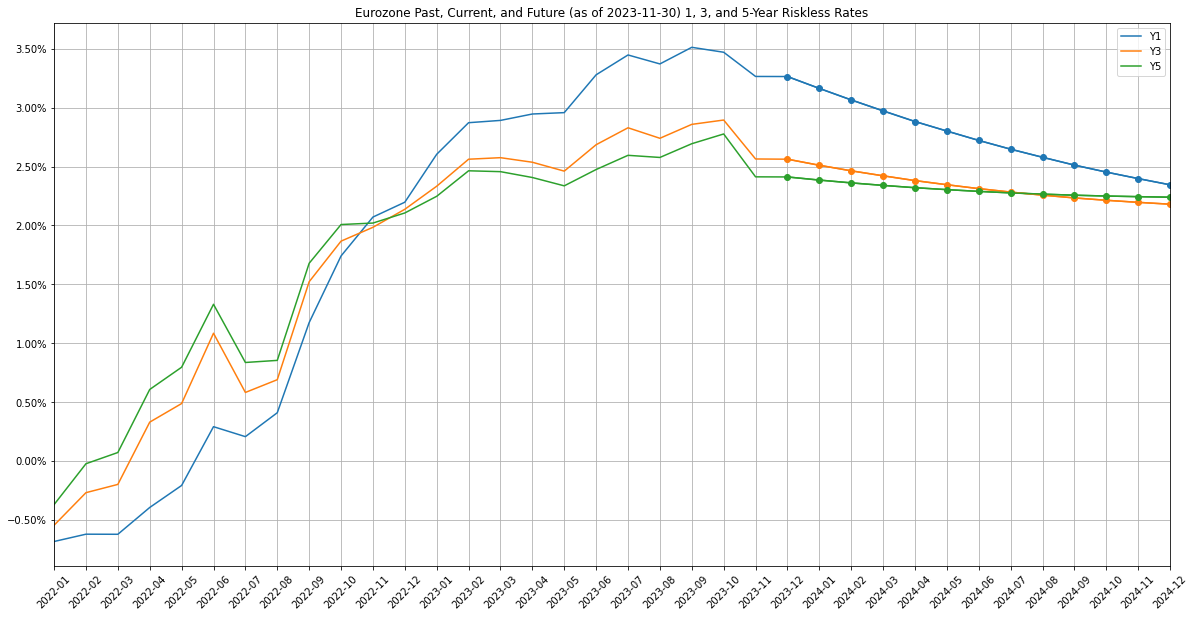

In [19]:
maturiries_selection = maturities[::2]
ax = euro_riskless_rates.loc[:,maturiries_selection].plot(figsize=(20,10), grid=True,
                 title='Eurozone Past, Current, and Future (as of {:%Y-%m-%d}) 1, 3, and 5-Year Riskless Rates'
                                          .format(euro_spot_rates.index[-1].date()),
                 xticks=euro_riskless_rates.index, xlabel='', rot=45)
fwd_riskless_rates.loc[:,maturiries_selection].plot(ax=ax, grid=True, marker='o',
                                                    xticks=euro_riskless_rates.index, xlabel='',
                                                    yticks=np.arange(-.005, .04, 0.005),
                                                    rot=45, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax.legend(maturiries_selection)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, euro_riskless_rates.index)))

#### 1 Year Riskless Rates

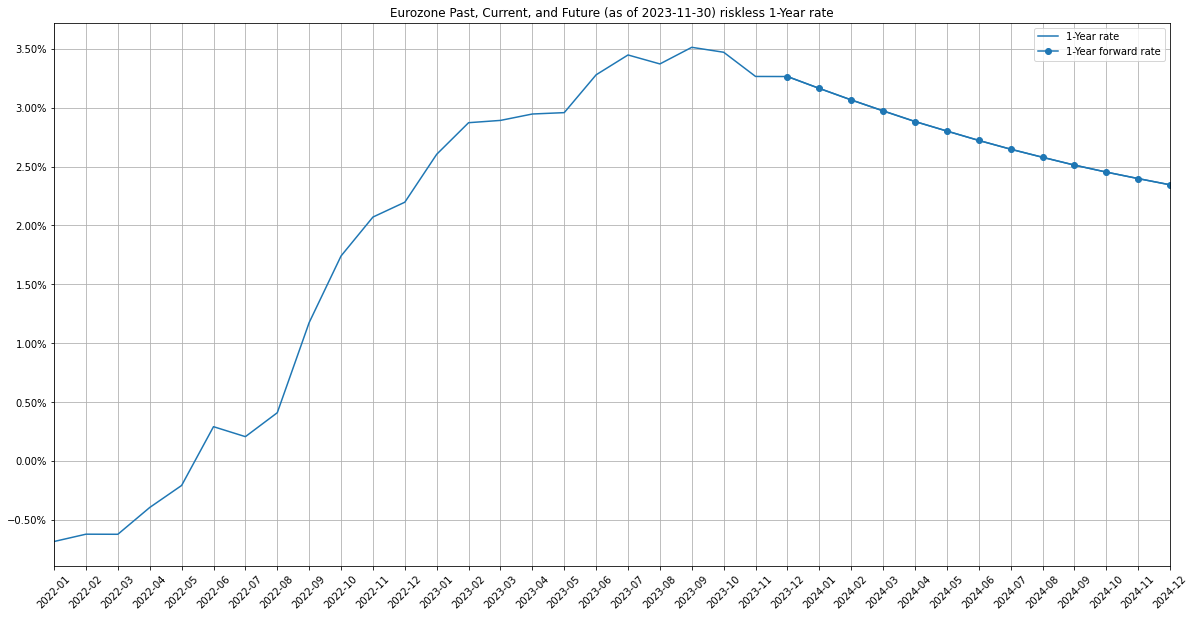

In [20]:
ax = euro_riskless_rates.loc[:,'Y1'].rename('1-Year rate').plot(figsize=(20,10), grid=True,
                 title='Eurozone Past, Current, and Future (as of {:%Y-%m-%d}) riskless 1-Year rate'
                                          .format(euro_spot_rates.index[-1].date()),
                 xticks=euro_riskless_rates.index, xlabel='', rot=45)
fwd_riskless_rates.loc[:,'Y1'].rename('1-Year forward rate').plot(ax=ax, grid=True, marker='o',
                                                                  xticks=euro_riskless_rates.index, xlabel='',
                                                                  yticks=np.arange(-.005, .04, 0.005),
                                                                  rot=45, color='#1f77b4')
ax.legend()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, euro_riskless_rates.index)))

#### 2 Year Riskless Rates

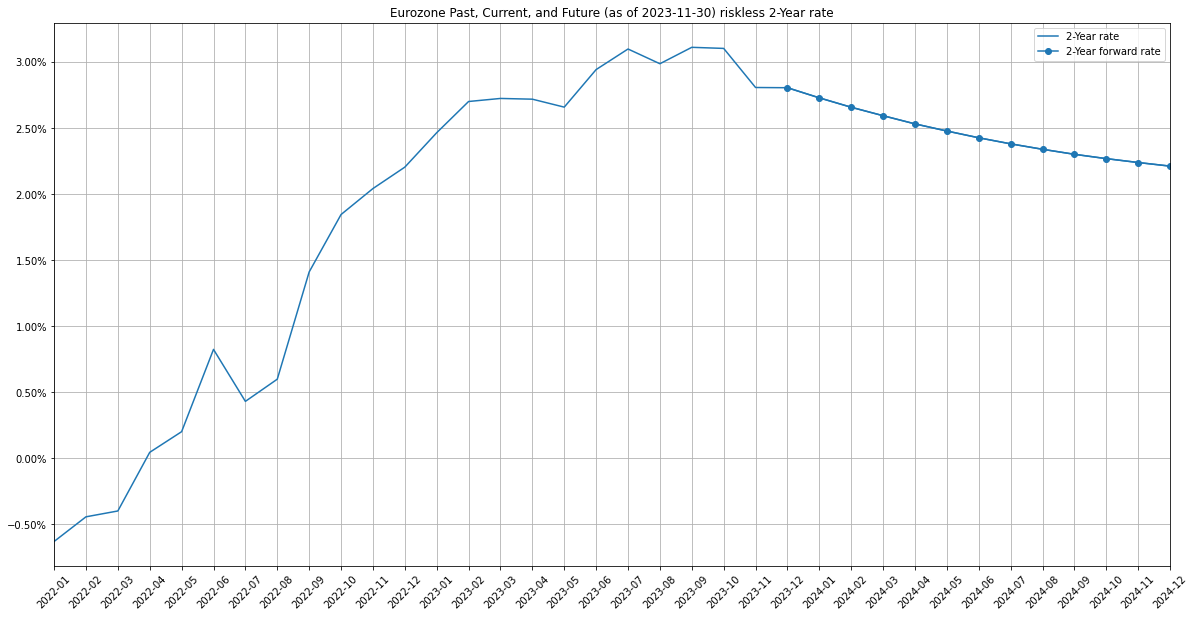

In [21]:
ax = euro_riskless_rates.loc[:,'Y2'].rename('2-Year rate').plot(figsize=(20,10), grid=True,
                 title='Eurozone Past, Current, and Future (as of {:%Y-%m-%d}) riskless 2-Year rate'
                                          .format(euro_spot_rates.index[-1].date()),
                 xticks=euro_riskless_rates.index, xlabel='', rot=45)
fwd_riskless_rates.loc[:,'Y2'].rename('2-Year forward rate').plot(ax=ax, grid=True, marker='o',
                                                                  xticks=euro_riskless_rates.index, xlabel='',
                                                                  rot=45, color='#1f77b4')
ax.legend()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, euro_riskless_rates.index)))

#### 3 Year Riskless Rate

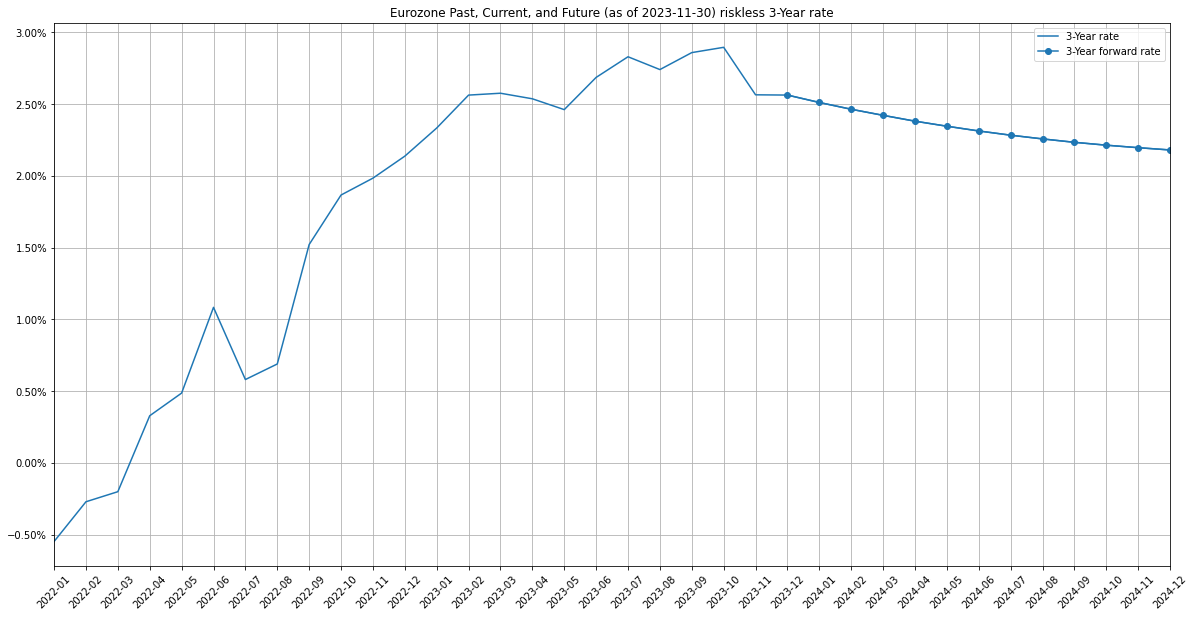

In [22]:
ax = euro_riskless_rates.loc[:,'Y3'].rename('3-Year rate').plot(figsize=(20,10), grid=True,
                 title='Eurozone Past, Current, and Future (as of {:%Y-%m-%d}) riskless 3-Year rate'
                                          .format(euro_spot_rates.index[-1].date()),
                 xticks=euro_riskless_rates.index, xlabel='', rot=45)
fwd_riskless_rates.loc[:,'Y3'].rename('3-Year forward rate').plot(ax=ax, grid=True, marker='o',
                                                                  xticks=euro_riskless_rates.index, xlabel='',
                                                                  rot=45, color='#1f77b4')
ax.legend()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, euro_riskless_rates.index)))

#### 5 Year Riskless Rate

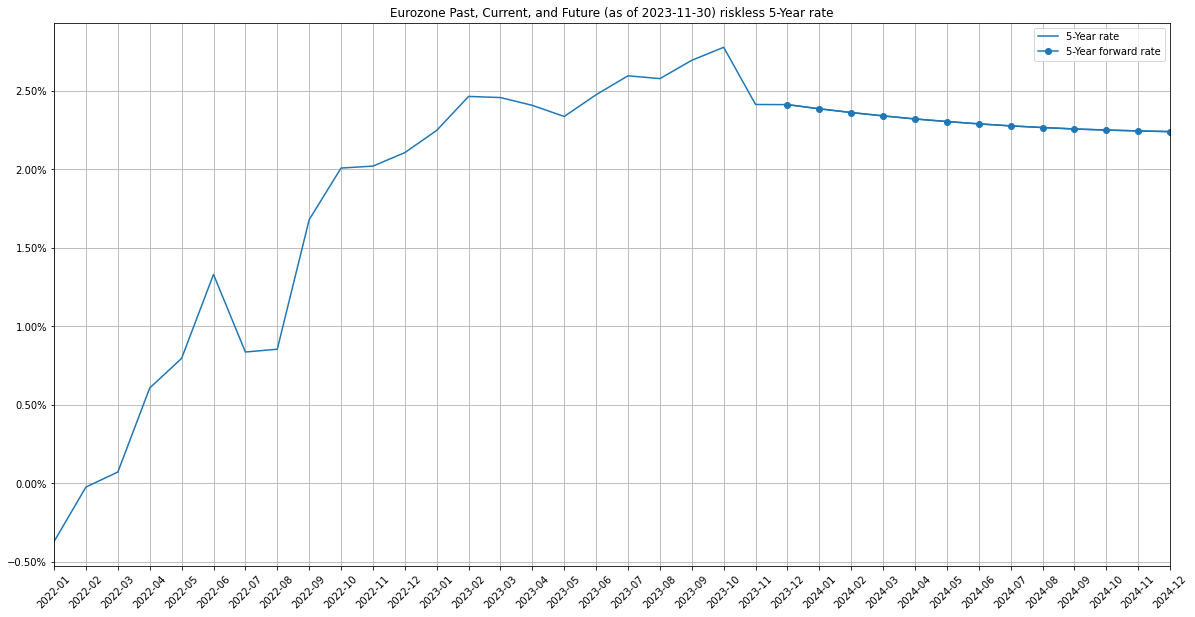

In [23]:
ax = euro_riskless_rates.loc[:,'Y5'].rename('5-Year rate').plot(figsize=(20,10), grid=True,
                 title='Eurozone Past, Current, and Future (as of {:%Y-%m-%d}) riskless 5-Year rate'
                                          .format(euro_spot_rates.index[-1].date()),
                 xticks=euro_riskless_rates.index, xlabel='', rot=45)
fwd_riskless_rates.loc[:,'Y5'].rename('5-Year forward rate').plot(ax=ax, grid=True, marker='o',
                                                                  xticks=euro_riskless_rates.index, xlabel='',
                                                                  rot=45, color='#1f77b4')
ax.legend()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, euro_riskless_rates.index)))